In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torchsummary import summary
from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

In [24]:
device = 'cuda'
epochs = 20
batch_size = 128
noise_dimension = 64

#Adam
lr = 2e-4
beta_1 = 0.5
beta_2 = 0.999

In [5]:
train_augmentations = T.Compose([
    T.RandomRotation((-20, +20)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

In [6]:
trainset = datasets.MNIST('MNIST/', download=True, train=True, transform=train_augmentations)

100%|██████████| 9912422/9912422 [00:00<00:00, 129774451.47it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 38057082.57it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39642156.83it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7227059.47it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



In [28]:
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
dataiter = iter(train_loader)
images, _ = dataiter.__next__()
print(images.shape)

torch.Size([128, 1, 28, 28])


In [29]:
def show_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

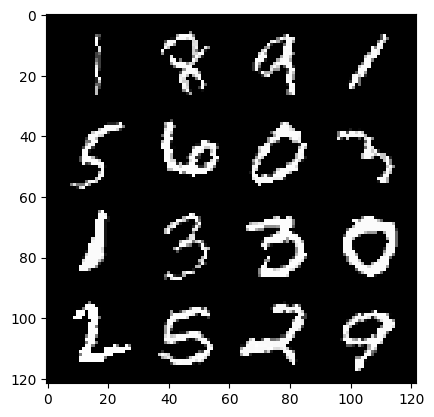

In [30]:
show_images(images, num_images = 16)

In [11]:
def d_block(input_channels, output_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(input_channels, output_channels, kernel_size, stride),
      nn.BatchNorm2d(output_channels),
      nn.LeakyReLU(0.2)
  )

In [12]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.block_1 = d_block(1, 16, (3, 3), 2)
    self.block_2 = d_block(16, 32, (5, 5) , 2)
    self.block_3 = d_block(32, 64, (5, 5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(64, 1)

  def forward(self, images):

    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [13]:
D = Discriminator()
D.to(device)

summary(D, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [14]:
def g_block(input_channels, output_channels, kernel_size, stride, last_block = False):
  if (last_block):
    return nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
        nn.Tanh()
    )
  else:
    return nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
        nn.BatchNorm2d(output_channels),
        nn.ReLU()
    )

In [17]:
class Generator(nn.Module):

  def __init__(self, noice_dimension):
    super(Generator, self).__init__()
    self.noise_dimension = noise_dimension

    self.block_1 = g_block(noise_dimension, 256, (3, 3), 1)
    self.block_2 = g_block(256, 128, (4, 4), 1)
    self.block_3 = g_block(128, 64, (3, 3), 2)

    self.block_4 = g_block(64, 1, (4, 4), 2, last_block = True)

  def forward(self, noise):
    x = noise.view(-1, self.noise_dimension, 1, 1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4

In [18]:
G = Generator(noise_dimension)
G.to(device)

summary(G, input_size=(noise_dimension, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [19]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [20]:
D = D.apply(weights_init)
G = G.apply(weights_init)

In [21]:
def real_label(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_label(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  gronud_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, gronud_truth)
  return loss

In [25]:
D_opt = torch.optim.AdamW(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.AdamW(G.parameters(), lr = lr, betas = (beta_1, beta_2))

In [26]:
def train_function(num_epochs):
  for i in range(num_epochs):
    d_loss = 0.0
    g_loss = 0.0

    for real_images, _ in train_loader:
      real_images = real_images.to(device)
      noise = torch.randn(batch_size, noise_dimension, device = device)

      D_opt.zero_grad()

      fake_images = G(noise)
      D_pred = D(fake_images)
      D_fake_loss = fake_label(D_pred)

      D_pred = D(real_images)
      D_real_loss = real_label(D_pred)

      D_loss = (D_fake_loss + D_real_loss) / 2
      d_loss += D_loss.item()
      D_loss.backward()
      D_opt.step()

      G_opt.zero_grad()

      noise = torch.randn(batch_size, noise_dimension, device = device)
      fake_images = G(noise)
      D_pred = D(fake_images)
      G_loss = real_label(D_pred)
      g_loss += G_loss.item()

      G_loss.backward()
      G_opt.step()

    avg_d_loss = d_loss / len(train_loader)
    avg_g_loss = g_loss / len(train_loader)
    print("Epoch : {} | D_loss : {} | G_loss : {}".format(i+1, avg_d_loss, avg_g_loss))

train_function(epochs)

Epoch : 1 | D_loss : 0.6727491769709313 | G_loss : 0.6964882983327675
Epoch : 2 | D_loss : 0.6687974369347985 | G_loss : 0.7189224453877284
Epoch : 3 | D_loss : 0.67927470835033 | G_loss : 0.7097447841152199
Epoch : 4 | D_loss : 0.6750299858131896 | G_loss : 0.7181012048395966
Epoch : 5 | D_loss : 0.6668362775082781 | G_loss : 0.7306177394984882
Epoch : 6 | D_loss : 0.657844174391171 | G_loss : 0.7457501548948064
Epoch : 7 | D_loss : 0.6450859425164489 | G_loss : 0.76792095172634
Epoch : 8 | D_loss : 0.6314519812811666 | G_loss : 0.7939575680537518
Epoch : 9 | D_loss : 0.6175664969598815 | G_loss : 0.8232113419056956
Epoch : 10 | D_loss : 0.6076417269228872 | G_loss : 0.8455437579388811
Epoch : 11 | D_loss : 0.6004961229590718 | G_loss : 0.8670439959080742
Epoch : 12 | D_loss : 0.591054752818557 | G_loss : 0.8902347143779177
Epoch : 13 | D_loss : 0.5834019167591006 | G_loss : 0.9115590901771334
Epoch : 14 | D_loss : 0.5766706933090682 | G_loss : 0.9303869981247225
Epoch : 15 | D_loss :

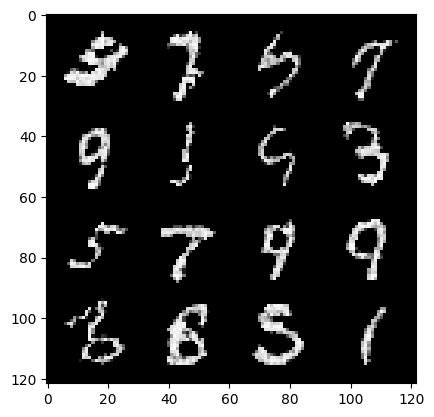

In [27]:
noise = torch.randn(batch_size, noise_dimension, device = device)
generated_image = G(noise)

show_images(generated_image)